In [99]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import sqlite3
import get_power_plants
from geodata_processing import download_gdf
import numpy

In [2]:
USA = download_gdf(country='USA',resolution=1)

CA_boundary = USA[USA.NAME_1=='California'].geometry

In [88]:
from shapely.geometry import Point
import random

def generate_random_coordinates_within_multipolygon(pol, num_points):
    points = []
    multipolygon = pol.bounds.to_numpy()
    min_x, min_y, max_x, max_y = multipolygon[0]
    while len(points) < num_points:
        random_point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if pol.contains(random_point).iloc[0]:
            points.append((random_point.x, random_point.y))
    return points

random_points = generate_random_coordinates_within_multipolygon(CA_boundary, 2000)


In [89]:
CA = get_power_plants.get_uspvdb('CA')

In [90]:
known_plants = CA[['xlong','ylat']].to_numpy()

In [91]:
from shapely.geometry import Point
from geopandas.tools import sjoin
import random

def filter_coordinates_by_distance_gdf(random_points, set_A, distance_threshold_km):
    # Convert random_points and set_A into GeoDataFrames
    random_points_gdf = geopandas.GeoDataFrame(geometry=[Point(xy) for xy in random_points])
    set_A_gdf = geopandas.GeoDataFrame(geometry=[Point(xy) for xy in set_A])

    # Buffer set_A by the distance threshold
    set_A_gdf = set_A_gdf.set_crs(epsg=4326)  # Assuming the coordinates are in WGS84
    set_A_gdf = set_A_gdf.to_crs(epsg=3857)   # Convert to a metric system (meters)
    set_A_gdf['geometry'] = set_A_gdf.buffer(distance_threshold_km * 1000)  # Buffer in meters

    # Convert random points to the same CRS
    random_points_gdf = random_points_gdf.set_crs(epsg=4326)
    random_points_gdf = random_points_gdf.to_crs(epsg=3857)

    # Perform a spatial join to find random points within the buffer zones
    joined_gdf = sjoin(random_points_gdf, set_A_gdf, how="left", op="within")

    # Filter out points that are within the distance threshold (those with a match in set_A)
    filtered_gdf = joined_gdf[joined_gdf.index_right.isna()]

    # Convert filtered points back to EPSG:4326 (latitude, longitude)
    filtered_gdf = filtered_gdf.to_crs(epsg=4326)

    # Convert filtered points back to a list of tuples (x, y)
    filtered_points = [(point.x, point.y) for point in filtered_gdf.geometry]

    return filtered_points

# Example usage
# Assuming 'set_A' is a list of tuples (x, y) representing 500 separate coordinates
# And 'random_points' is the list of random coordinates generated earlier

distance_threshold_km = 10  # 10 km threshold
filtered_random_points = filter_coordinates_by_distance_gdf(random_points, known_plants, distance_threshold_km)


/Users/kaorukure/.pyenv/versions/3.10.6/envs/illuminating_horizons/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [104]:
len(filtered_random_points)

1777

In [97]:
absent_points = random.sample(filtered_random_points,len(known_plants))

In [110]:

known_plants_df = pd.DataFrame(known_plants, columns=['Longitude', 'Latitude'])
absent_points_df = pd.DataFrame(absent_points, columns=['Longitude', 'Latitude'])

# Add labels
known_plants_df['have_plant'] = 1
absent_points_df['have_plant'] = 0

# Concatenate the DataFrames
combined_df = pd.concat([known_plants_df, absent_points_df], ignore_index=True)


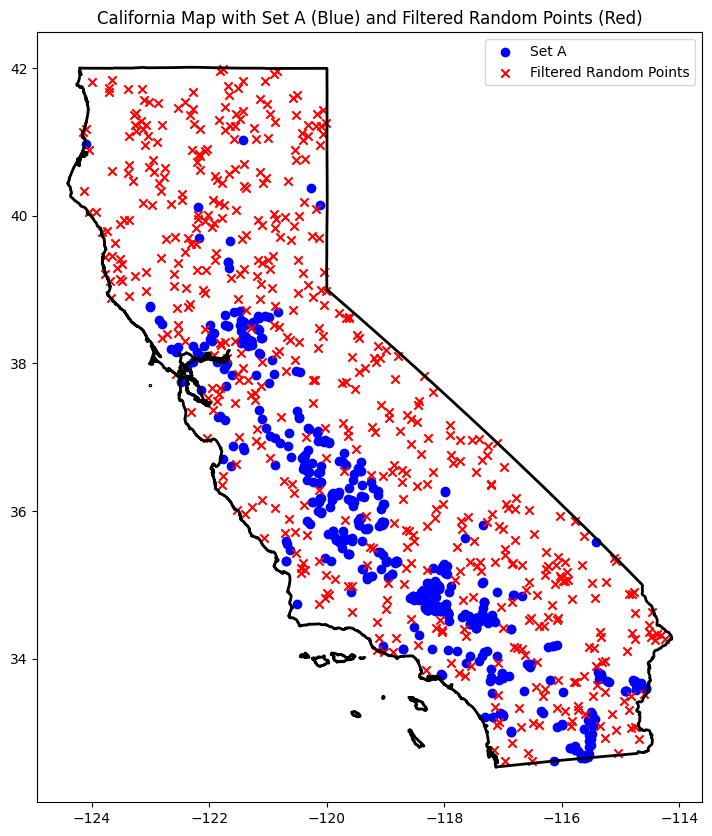

In [105]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# Convert to GeoDataFrames
set_A_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in known_plants], crs="EPSG:4326")
filtered_random_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in absent_points], crs="EPSG:4326")

# Create a GeoDataFrame for California
california_gdf = gpd.GeoDataFrame(geometry=[CA_boundary.iloc[0]], crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
set_A_gdf.plot(ax=ax, color='blue', marker='o', label='Set A')
filtered_random_gdf.plot(ax=ax, color='red', marker='x', label='Filtered Random Points')

# Add labels and legend
plt.title('California Map with Set A (Blue) and Filtered Random Points (Red)')
plt.legend()

# Show plot
plt.show()

In [109]:
combined_df

,Longitude,Latitude,Label
0,-120.109391,36.177598,1
1,-116.327979,33.265240,1
2,-118.304671,34.707428,1
3,-118.274109,34.708588,1
4,-120.115552,36.175836,1
...,...,...,...
1075,-115.353773,33.093003,0
1076,-116.064872,34.553642,0
1077,-122.884334,41.524390,0
1078,-115.765774,33.679898,0
